In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve

In [2]:
#import the data
file_path = '/content/drive/My Drive/Crime_Data_from_2020_to_Present.csv'
data = pd.read_csv(file_path)

In [3]:
data.shape

(694915, 28)

In [4]:
data.drop(['DR_NO', 'Date Rptd', 'Rpt Dist No' , 'Part 1-2',  'Crm Cd 1','Status','Status Desc', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4',  'LOCATION','LAT','LON','Cross Street', 'Mocodes', 'Weapon Used Cd','Weapon Desc' ], axis=1, inplace=True)
data.head(1)

,DATE OCC,TIME OCC,AREA,AREA NAME,Crm Cd,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,Premis Cd,Premis Desc
0,01/08/2020 12:00:00 AM,2230,3,Southwest,624,BATTERY - SIMPLE ASSAULT,36,F,B,501.0,SINGLE FAMILY DWELLING


In [5]:
# Handle missing values
data.dropna(axis=0, inplace=True)
data.reset_index(drop=True, inplace=True)

# Remove duplicates
data.drop_duplicates(inplace=True)

data.shape

(600869, 11)

In [6]:
Q1 = data['Vict Age'].quantile(0.25)
Q3 = data['Vict Age'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

data = data[(data['Vict Age'] >= lower_bound) & (data['Vict Age'] <= upper_bound) & (data['Vict Age'] > 0) & (data['Vict Age'] != -1)]

In [7]:
# Split 'DATE OCC' into year, month and day.
data['DATE OCC'] = pd.to_datetime(data['DATE OCC'])
data['YEAR_OCC'] = data['DATE OCC'].dt.year
data['MONTH_OCC'] = data['DATE OCC'].dt.month
data['DAY_OCC'] = data['DATE OCC'].dt.day
data.head(1)

,DATE OCC,TIME OCC,AREA,AREA NAME,Crm Cd,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,Premis Cd,Premis Desc,YEAR_OCC,MONTH_OCC,DAY_OCC
0,2020-01-08,2230,3,Southwest,624,BATTERY - SIMPLE ASSAULT,36,F,B,501.0,SINGLE FAMILY DWELLING,2020,1,8


In [8]:
data.drop([ 'AREA NAME', 'Crm Cd Desc','Premis Desc' ], axis=1, inplace=True)
data.head(1)

,DATE OCC,TIME OCC,AREA,Crm Cd,Vict Age,Vict Sex,Vict Descent,Premis Cd,YEAR_OCC,MONTH_OCC,DAY_OCC
0,2020-01-08,2230,3,624,36,F,B,501.0,2020,1,8


In [9]:
#identifying the top 3 crimes

value_counts = data['Crm Cd'].value_counts()
filtered_values = value_counts[value_counts < 40000]
rows_to_remove = data[data['Crm Cd'].isin(filtered_values.index)]

updated_df = data[~data.index.isin(rows_to_remove.index)]

In [10]:
updated_df
value_counts = updated_df['Crm Cd'].value_counts()
value_counts

624    53630
354    44153
330    42139
Name: Crm Cd, dtype: int64

In [11]:
updated_df.shape

(139922, 11)

In [12]:
data=updated_df

In [13]:
# Preprocess the data
data['DAY_OF_WEEK'] = pd.to_datetime(data['DATE OCC']).dt.weekday
data = data[['AREA', 'Vict Age', 'Vict Sex', 'Vict Descent', 'Crm Cd', 'DAY_OF_WEEK', 'TIME OCC','Premis Cd']]  # Select relevant features
target = data['Crm Cd']  # Target variable
data = data.drop('Crm Cd', axis=1)  # Remove the target variable from the features

<ipython-input-13-c27db799d4d5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['DAY_OF_WEEK'] = pd.to_datetime(data['DATE OCC']).dt.weekday


In [14]:
# Convert categorical variables into numerical representations using LabelEncoder
label_encoder = LabelEncoder()
data['Vict Sex'] = label_encoder.fit_transform(data['Vict Sex'])
data['Vict Descent'] = label_encoder.fit_transform(data['Vict Descent'])

In [15]:
# Perform feature scaling on numerical features
scaler = StandardScaler()
data[['Vict Age', 'DAY_OF_WEEK', 'TIME OCC','Premis Cd']] = scaler.fit_transform(data[['Vict Age', 'DAY_OF_WEEK', 'TIME OCC','Premis Cd']])

In [16]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

In [17]:
# Model Selection and Training
model = RandomForestClassifier()  # Create a Random Forest model
model.fit(X_train, y_train)  # Train the model on the training data

RandomForestClassifier()

In [18]:
# Model Evaluation
y_pred = model.predict(X_test)  # Perform prediction on the testing data
accuracy = accuracy_score(y_test, y_pred)  # Evaluate the model accuracy
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

In [19]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.7406825084866893
Precision: 0.7393282885401429
Recall: 0.7406825084866893
F1 Score: 0.7393027105117499


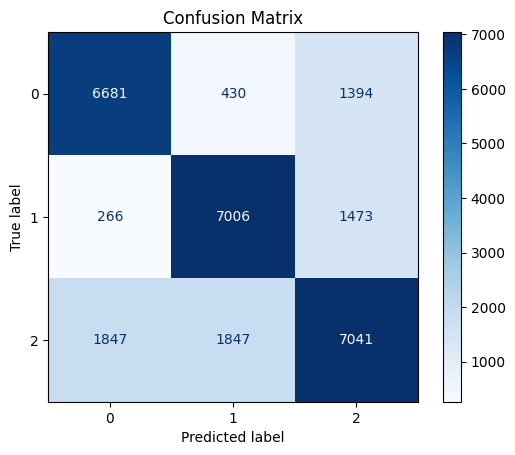

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred) 
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

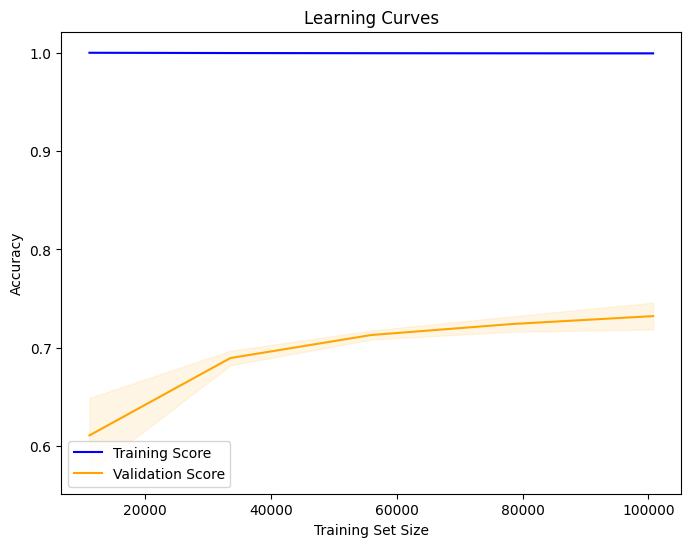

In [21]:
# Define a function to plot learning curves
def plot_learning_curves(estimator, X, y, train_sizes, cv):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, train_sizes=train_sizes, cv=cv, scoring='accuracy')

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, label='Training Score', color='blue')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    plt.plot(train_sizes, test_mean, label='Validation Score', color='orange')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='orange')

    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.title('Learning Curves')
    plt.legend()
    plt.show()

# Set the train sizes for the learning curves
train_sizes = [0.1, 0.3, 0.5, 0.7, 0.9]

# Plot the learning curves
plot_learning_curves(model, data, target, train_sizes, cv=5)
